# Data Preparation Workflow

## Set Up the Jupyter Notebook for Analysis

Note: We have our new package called swat - SAS Scripting Wrapper for Analytics Transfer - available on GitHub via pip install <br>

In [1]:
# Import necessary packages and modules
import swat
%matplotlib inline

# Set the connection by specifying the hostname, port, username, and password
conn = swat.CAS(hostname, port, username, password)

# Get the hmeq csv file from SAS support documentation and lift into memory
castbl = conn.read_csv('http://support.sas.com/documentation/onlinedoc/viya/exampledatasets/hmeq.csv', casout = 'hmeq')
castbl.replace = True

## Examine the first few rows

In [2]:
# Assign the variable name df to the new CASTable object
df = conn.CASTable('hmeq')

# Perform the head method to return the first 5 rows
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


## Create new features

In [3]:
# How much of their mortgage have they paid off?
df['MORTPAID'] = df['VALUE'] - df['MORTDUE']
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,MORTPAID
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN,13165.0
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN,-1653.0
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN,3200.0
3,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN,14200.0


In [4]:
# What percent of the time does this happen?
df.query('MORTPAID < 0')['MORTPAID'].count()/len(df)

0.0085570469798657723

## Examine numeric variable distribution

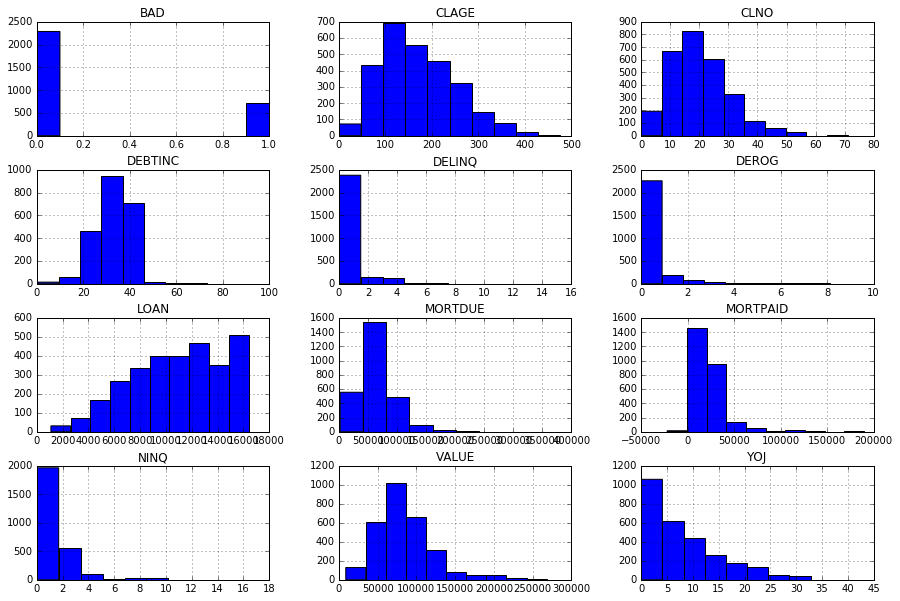

In [5]:
# Use the pandas/matplotlib method for plotting a histogram of all numeric variables
df.hist(figsize = (15, 10));

## Examine summary statistics

In [6]:
# Use the pandas describe method, then switch rows and columns
summary = df.describe(include = 'all').transpose()
summary

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
BAD,5960,2,0,4771,0.199497,0.399656,0,0,0,0,1
LOAN,5960,540,15000,105,18608,11207.5,1100,11100,16300,23300,89900
MORTDUE,5442,5053,42000,11,73760.8,44457.6,2063,46268,65019,91491,399550
VALUE,5848,5381,60000,15,101776,57385.8,8000,66069,89235.5,119832,855909
REASON,5960,2,DebtCon,3928,NaN,NaN,DebtCon,NaN,NaN,NaN,HomeImp
JOB,5960,6,Other,2388,NaN,NaN,Mgr,NaN,NaN,NaN,Self
YOJ,5445,99,0,415,8.92227,7.57398,0,3,7,13,41
DEROG,5252,11,0,4527,0.25457,0.846047,0,0,0,0,10
DELINQ,5380,14,0,4179,0.449442,1.12727,0,0,0,0,15
CLAGE,5652,5314,206.967,7,179.766,85.8101,0,115.103,173.467,231.575,1168.23


## Is there an issue with missing data?

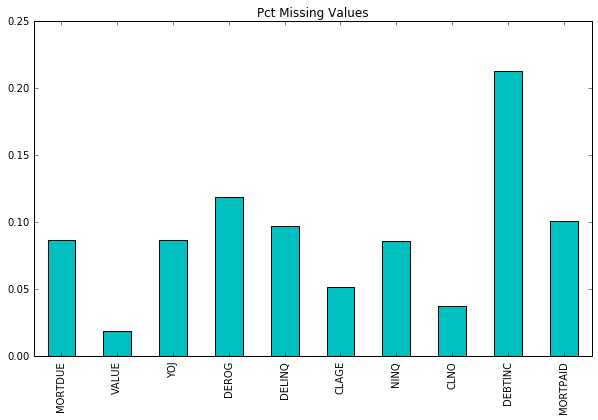

In [7]:
# Create percent missing column for plotting
summary['pctmiss'] = (len(df) - summary['count'])/len(df)

# Make a bar graph using pandas/matplotlib functionality
summary.query('pctmiss > 0')['pctmiss'].plot('bar', title = 'Pct Missing Values', figsize = (10, 6), color = 'c');

## The variables need to be imputed for missing values

In [8]:
# This is using the CAS action impute - really nice method for imputing all variables at once
## Impute the median for numeric, most common for categorical
df.impute(
    methodContinuous = 'MEDIAN',
    methodNominal    = 'MODE',
    inputs           = list(summary.index[1:]), # exclude target column
    copyAllVars      = True,
    casOut           = castbl
)

,Variable,ImputeTech,ResultVar,N,NMiss,ImputedValueContinuous,ImputedValueNominal
0,LOAN,Median,IMP_LOAN,5960.0,0.0,16300.000000,
1,MORTDUE,Median,IMP_MORTDUE,5442.0,518.0,65019.000000,
2,VALUE,Median,IMP_VALUE,5848.0,112.0,89235.500000,
3,REASON,Mode,IMP_REASON,5708.0,252.0,NaN,DebtCon
4,JOB,Mode,IMP_JOB,5681.0,279.0,NaN,Other
5,YOJ,Median,IMP_YOJ,5445.0,515.0,7.000000,
6,DEROG,Median,IMP_DEROG,5252.0,708.0,0.000000,
7,DELINQ,Median,IMP_DELINQ,5380.0,580.0,0.000000,
8,CLAGE,Median,IMP_CLAGE,5652.0,308.0,173.466667,
9,NINQ,Median,IMP_NINQ,5450.0,510.0,1.000000,


## Create partition indicator so models won't overfit

In [9]:
# Load the sampling actionset
conn.loadactionset('sampling')

# Do a simple random sample with a 70/30 split
df.srs(samppct = 30, partind = True, seed = 1, output = dict(casout = castbl, copyvars = 'all'))

# What percentage is in each split?
castbl['_PartInd_'].groupby('_PartInd_').count()/len(castbl)

NOTE: Added action set 'sampling'.
NOTE: Using SEED=1 for sampling.


_PartInd_
0.0    0.7
1.0    0.3
Name: _PartInd_, dtype: float64

## Make sure the dataset looks good

In [10]:
castbl.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,...,IMP_LOAN,IMP_MORTDUE,IMP_MORTPAID,IMP_NINQ,IMP_VALUE,IMP_YOJ,IMP_JOB,IMP_REASON,MORTPAID,_PartInd_
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,...,1100.0,25860.0,13165.0,1.0,39025.0,10.5,Other,HomeImp,13165.0,0.0
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,...,1300.0,70053.0,-1653.0,0.0,68400.0,7.0,Other,HomeImp,-1653.0,0.0
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,...,1500.0,13500.0,3200.0,1.0,16700.0,4.0,Other,HomeImp,3200.0,0.0
3,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,...,1500.0,65019.0,26623.0,1.0,89235.5,7.0,Other,DebtCon,NaN,0.0
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,...,1700.0,97800.0,14200.0,0.0,112000.0,3.0,Office,HomeImp,14200.0,0.0


## Promote the table to public memory

In [11]:
# This allows me to share my data across sessions and with other colleagues
conn.promote(name = castbl, targetlib = 'public', target = 'hmeq_prepped')

## Ensure that everything worked as intended

In [12]:
# Verify that hmeq_prepped has made it into the public caslib
conn.tableinfo(caslib = 'public')['TableInfo'].query('Name == "HMEQ_PREPPED"')

,Name,Rows,Columns,Encoding,CreateTimeFormatted,ModTimeFormatted,JavaCharSet,CreateTime,ModTime,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier
7,HMEQ_PREPPED,5960,28,utf-8,01Aug2017:21:17:11,01Aug2017:21:17:11,UTF8,1.817241e+09,1.817241e+09,1,0,0,,,0,jelueb,


In [13]:
# End the session
conn.endsession()

+ Elapsed: 0.00457s, user: 0.001s, sys: 0.005s, mem: 0.114mb